In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV


### Данные

The breast cancer wisconsin dataset (classification).

Classes 	2

Samples per class 	212(M),357(B)

Samples total 	569

Dimensionality 	30

Features 	real, positive



In [165]:
cancer = load_breast_cancer()

In [ ]:
cancer

In [169]:
df = pd.DataFrame(cancer.data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [57]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.33)

In [58]:
clf = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=10,
                                 min_samples_split=5,
                                 min_samples_leaf=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [59]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [60]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,64,1
1,14,109


In [61]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.98      0.90        65
           1       0.99      0.89      0.94       123

    accuracy                           0.92       188
   macro avg       0.91      0.94      0.92       188
weighted avg       0.93      0.92      0.92       188



In [132]:
err_train, err_test = [], []

min_depth = 1
max_depth = 50

for i in range(min_depth, max_depth + 1):
    clf = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=i)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    #scores = cross_val_score(clf, cancer.data, cancer.target, cv = 5)
    #acc_test = scores.mean()
    
    err_train.append(1 - acc_train)
    err_test.append(1 - acc_test)

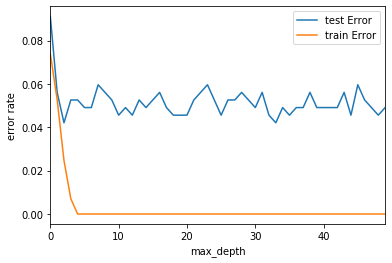

In [133]:
plt.plot(err_test, label = "test Error")
plt.plot(err_train, label = "train Error")

plt.xlim(min_depth - 1, max_depth - 1)
plt.xlabel("max_depth")
plt.ylabel("error rate")
plt.legend()
plt.show()

In [129]:
#RANDOM_STATE = 2019

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               min_samples_leaf=5)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               min_samples_leaf=5,
                               oob_score=True)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               min_samples_leaf=5,
                               oob_score=True))
]

In [65]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [66]:
min_estimators = 15
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(cancer.data, cancer.target)
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

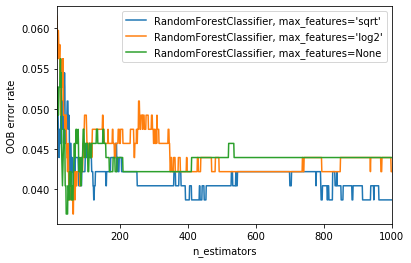

In [67]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [70]:
rf_clf = RandomForestClassifier(n_estimators=500,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               min_samples_leaf=5,
                               min_samples_split=5)

In [71]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=True)

In [72]:
y_pred_train = rf_clf.predict(X_train)
y_pred_test = rf_clf.predict(X_test)

conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=rf_clf.classes_, columns=rf_clf.classes_)
conf_mat

,0,1
0,62,3
1,7,116


In [73]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        65
           1       0.97      0.94      0.96       123

    accuracy                           0.95       188
   macro avg       0.94      0.95      0.94       188
weighted avg       0.95      0.95      0.95       188



In [75]:
err_oob, err_train, err_test = list(), list(), list()
for n in range(15,500):
    rf_clf = RandomForestClassifier(n_estimators=n,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               min_samples_leaf=5,
                               min_samples_split=5)
    rf_clf.fit(X_train, y_train)
    
    y_pred_train = rf_clf.predict(X_train)
    y_pred_test = rf_clf.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    oob = 1 - rf_clf.oob_score_
    err_oob.append(oob)
    err_train.append(1 - acc_train)
    err_test.append(1 - acc_test)

/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


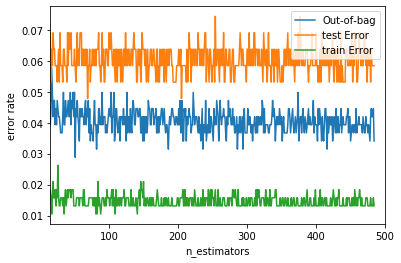

In [76]:
plt.plot(err_oob, label = "Out-of-bag")
plt.plot(err_test, label = "test Error")
plt.plot(err_train, label = "train Error")

plt.xlim(15, 500)
plt.xlabel("n_estimators")
plt.ylabel("error rate")
plt.legend()
plt.show()

In [77]:
y_pred_test = clf.predict(X_test)

In [78]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        65
           1       0.99      0.98      0.99       123

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



In [135]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.5)
#X_svm, X_rf, y_svm, y_rf = train_test_split(X_train, y_train, test_size=0.5)

In [136]:
len(X_test)

285

In [137]:
rf_clf = RandomForestClassifier(n_estimators=15,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               min_samples_leaf=5,
                               min_samples_split=5)

sc = 0
n = 15

for n_trees in range(15, 200 + 1):
    rf_clf.set_params(n_estimators=n_trees)
    rf_clf.fit(X_train, y_train)
    oob = rf_clf.oob_score_
    if oob > sc:
        sc = oob
        n = n_trees
#     scores = cross_val_score(rf_clf, X_rf, y_rf, cv=5, scoring = 'accuracy')
#     if (scores.mean() >= sc):
#         sc = scores.mean()
#         n = n_trees

In [138]:
n

166

In [139]:
sc

0.9612676056338029

In [140]:
rf_clf = RandomForestClassifier(n_estimators=n, min_samples_leaf=5, min_samples_split=5, max_features='sqrt')
rf_clf.fit(X_train, y_train)

y_pred_test = rf_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       110
           1       0.95      0.99      0.97       175

    accuracy                           0.96       285
   macro avg       0.97      0.95      0.96       285
weighted avg       0.96      0.96      0.96       285



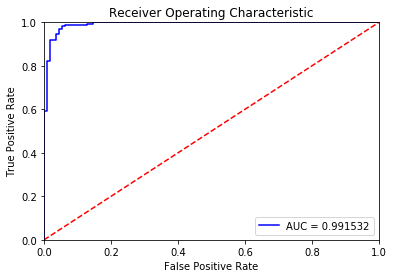

In [164]:
probs = rf_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [150]:
probs

array([[9.85370052e-03, 9.90146299e-01],
       [9.78780055e-01, 2.12199447e-02],
       [3.96696888e-02, 9.60330311e-01],
       [9.80319881e-03, 9.90196801e-01],
       [9.78207168e-01, 2.17928323e-02],
       [3.23940785e-02, 9.67605922e-01],
       [9.51992678e-01, 4.80073223e-02],
       [2.03815261e-02, 9.79618474e-01],
       [9.48794863e-01, 5.12051369e-02],
       [2.19945717e-02, 9.78005428e-01],
       [5.27286326e-02, 9.47271367e-01],
       [3.34649955e-02, 9.66535004e-01],
       [9.83331127e-01, 1.66688733e-02],
       [9.85847720e-01, 1.41522801e-02],
       [4.55480879e-01, 5.44519121e-01],
       [9.71037814e-01, 2.89621857e-02],
       [8.60585198e-04, 9.99139415e-01],
       [2.59126667e-02, 9.74087333e-01],
       [6.67431631e-03, 9.93325684e-01],
       [5.47188755e-03, 9.94528112e-01],
       [1.03748327e-02, 9.89625167e-01],
       [7.29881927e-01, 2.70118073e-01],
       [5.10374833e-03, 9.94896252e-01],
       [5.21526100e-01, 4.78473900e-01],
       [1.642935

0.9533766233766233

In [198]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 1, 10]}
svc = SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train, y_train)
sorted(clf.cv_results_.keys())

/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [199]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [156]:
y_pred_svm = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       110
           1       0.95      0.97      0.96       175

    accuracy                           0.95       285
   macro avg       0.95      0.94      0.94       285
weighted avg       0.95      0.95      0.95       285



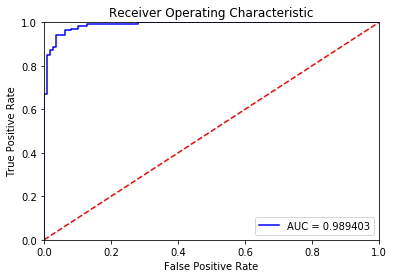

In [163]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [178]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(cancer.data)

In [179]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [189]:
y = pd.DataFrame(cancer.target, columns = ['target'])
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf

,principal component 1,principal component 2,target
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0
5,2.380247,3.949929,0
6,2.238883,-2.690031,0
7,2.143299,2.340244,0
8,3.174924,3.391813,0
9,6.351747,7.727174,0


In [190]:
finalDf['target']

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     1
20     1
21     1
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
539    1
540    1
541    1
542    1
543    1
544    1
545    1
546    1
547    1
548    1
549    1
550    1
551    1
552    1
553    1
554    1
555    1
556    1
557    1
558    1
559    1
560    1
561    1
562    0
563    0
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64

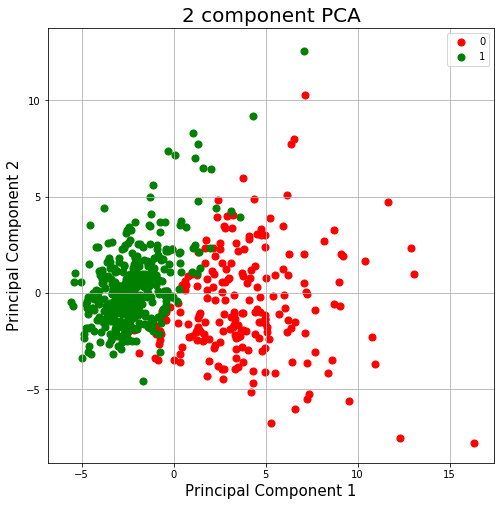

In [191]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()